In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

import torchvision.models as models

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
device=torch.device('cuda:0')
print(device)

cuda:0


### 1) I had applied transformation on dataset because MNIST dataset has 1channel but to apply transfer learning,it need 3channels i.e RGB 

In [7]:
transform = transforms.Compose([      
    transforms.Grayscale(3),    #converting 1 channel into 3 channel i.e RGB
    transforms.ToTensor(),
    ])

### 2) Load MNIST Dataset with batch size =128

In [8]:
batch_size = 128
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [9]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               ToTensor()
           )

In [10]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### 3)Visualization

In [11]:
def imshow(img,imagetitle):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #(3,28,28)->(28,28,3)
    plt.title(imagetitle)
    plt.show()


torch.Size([4, 3, 28, 28])


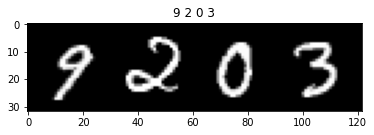

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images[:4].shape) # [4, 3, 28, 28] -> 4 no. of images,3 channel i.e RGB, height,width

imshow(torchvision.utils.make_grid(images[:4]),imagetitle=' '.join(classes[labels[j]] for j in range(4)))

# 4)Model

## 4.1)Load pretrained model

In [13]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4.2)Original model has out_feature 1000 but for our dataset we need 10. So I updated the last layer of the model.

In [15]:
resnet18.fc=nn.Linear(in_features=512, out_features=10, bias=True)

In [16]:
resnet18 = resnet18.to(device)
loss_fn = nn.CrossEntropyLoss() #loss function
opt = optim.Adam(resnet18.parameters(),lr=0.001) #optimizer

## 4.3)Infer Without Training

tensor([0, 0, 2, 2], device='cuda:0')


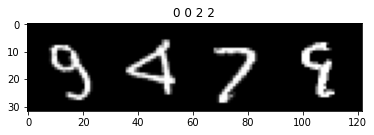

In [17]:
def infer(dataloader,model):
  tst=iter(dataloader).next()
  images,label=tst

  inputs, labels = images[:4].to(device), label[:4].to(device)
  outputs = model(inputs)
  _, pred = torch.max(outputs.data, 1) #_ contain max prob and pred contain index of that max prob 

  print(pred)
  imshow(torchvision.utils.make_grid(inputs.cpu()),imagetitle=' '.join(classes[pred[j]] for j in range(4)))
infer(trainloader,resnet18)  

## 4.4)Training Model

I had train the model till the count < stopAfter i.e train for 896 images.
Model evalution is done on 896 images training dataset as well as test data

In [18]:
stopAfter=int(np.floor(1000/batch_size))
print("Images to be Train =",stopAfter*batch_size)

Images to be Train = 896


In [19]:
def evaluation(dataloader, model):
    total, correct = 0, 0    
    count=0
    for data in dataloader:
        
        if(count==stopAfter):
          break
        else:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, pred = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()    
        count+=1                               
    return 100 * correct / total

In [20]:
%%time
max_epochs = 2

n_iters = np.ceil(len(trainset)/batch_size)
for epoch in range(max_epochs):

    count=0
    print('Epoch: %d/%d' % (epoch+1, max_epochs))
    for i, data in enumerate(trainloader, 0):        
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet18(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
                        
        #if i % 100 == 0:
        print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item())) 

        count+=1
        if(count==7):
          break        

Epoch: 1/2
Iteration: 0/469, Loss: 2.67
Iteration: 1/469, Loss: 1.72
Iteration: 2/469, Loss: 1.53
Iteration: 3/469, Loss: 1.02
Iteration: 4/469, Loss: 0.65
Iteration: 5/469, Loss: 0.41
Iteration: 6/469, Loss: 0.43
Epoch: 2/2
Iteration: 0/469, Loss: 0.26
Iteration: 1/469, Loss: 0.26
Iteration: 2/469, Loss: 0.32
Iteration: 3/469, Loss: 0.34
Iteration: 4/469, Loss: 0.17
Iteration: 5/469, Loss: 0.23
Iteration: 6/469, Loss: 0.42
CPU times: user 767 ms, sys: 205 ms, total: 972 ms
Wall time: 1.07 s


In [21]:
print('Train acc: %0.2f , Test acc: %0.2f' % (evaluation(trainloader,resnet18),evaluation(testloader,resnet18)))

Train acc: 92.41 , Test acc: 91.63


# Infer After Training

tensor([7, 2, 1, 0], device='cuda:0')


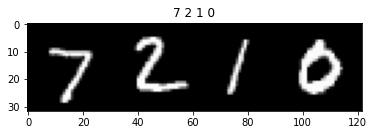

In [22]:
infer(testloader,resnet18) 